In [21]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
from halotools.sim_manager import FakeSim, CachedHaloCatalog
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import corner
from Corrfunc.theory.wp import wp
from numpy.linalg import inv
from scipy.stats import chi2
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from numpy.linalg import inv
import time

In [4]:
from astropy.table import Table 

__all__ = ('add_new_table_column', )

def add_new_table_column(table, new_colname, new_coltype, grouping_key,  
    aggregation_function, colnames_needed_by_function, 
    sorting_keys = None, table_is_already_sorted = False):

    assert type(table) == Table
    assert new_colname not in table.keys()
    assert grouping_key in table.keys()
    assert callable(aggregation_function) is True
    _ = iter(colnames_needed_by_function)
    for colname in colnames_needed_by_function:
        assert colname in table.keys()

    if sorting_keys == None:
        sorting_keys = [grouping_key]

    _ = iter(sorting_keys)
    for colname in sorting_keys:
        assert colname in table.keys()
    else:
        assert sorting_keys[0] == grouping_key
        
    if table_is_already_sorted is False:
        table.sort(sorting_keys)

    group_ids_data, idx_groups_data, group_richness_data = np.unique(
        table[grouping_key].data, 
        return_index = True, return_counts = True)

    dt = np.dtype([(new_colname, new_coltype)])
    
    result = np.zeros(len(table), dtype=dt[new_colname])

    func_arglist = [table[key].data for key in colnames_needed_by_function]

    for igroup, host_halo_id in enumerate(group_ids_data):
        first_igroup_idx = idx_groups_data[igroup]
        last_igroup_idx = first_igroup_idx + group_richness_data[igroup]
        group_data_list = [arg[first_igroup_idx:last_igroup_idx] for arg in func_arglist]
        result[first_igroup_idx:last_igroup_idx] = aggregation_function(*group_data_list)

    table[new_colname] = result

In [5]:
add_new_param = True
prop = 'combo'
Lbox = 400
pi_max = 60
dname = 'zehavi_data_file_21'

In [6]:
if '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '19' in dname:
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [7]:
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5')

In [34]:
time_last = time.time()
del(halocat.halo_table['combo'])
a = 0.5
if add_new_param == True:
    new_colname = 'combo'
    new_coltype = 'f4'
    grouping_key = 'halo_hostid'
    def lin_combo_mass_vmax(mass, vmax):
        return (mass**a)*(vmax**(1-a))
    aggregation_function = lin_combo_mass_vmax
    colnames_needed_by_function = ['halo_mvir','halo_vmax']
    sorting_keys = ['halo_hostid', 'halo_upid']
    add_new_table_column(halocat.halo_table, new_colname, new_coltype, grouping_key, 
                     aggregation_function, colnames_needed_by_function, 
                     sorting_keys=sorting_keys)
time_now = time.time()
print(time_now-time_last)

36.07472586631775


In [37]:
time_last=time.time()
del(halocat.halo_table['combo'])
a=.5
halocat.halo_table.add_column((halocat.halo_table['halo_mvir']**a)*(halocat.halo_table['halo_vmax']**(1-a)),name='combo')
print(time.time()-time_last)

0.04148507118225098


In [35]:
halocat.halo_table['combo'][0]

1324703.1

In [36]:
print((halocat.halo_table['combo'])[0])
print(((halocat.halo_table['halo_mvir']**a)*(halocat.halo_table['halo_vmax']**(1-a)))[0])

1324703.1
1324703.1


In [33]:
(halocat.halo_table['halo_mvir']**0.5)*(halocat.halo_table['halo_vmax']**(1-a))

1324703.1
2681352.0
1117474.8
1466933.4
1309029.0
4100381.0
905482.94
1185244.1
1379936.9
1390469.0
2802228.0


In [97]:
"""
model_instance = PrebuiltSubhaloModelFactory('behroozi10', redshift = 0, prim_haloprop_key=prop)
model_instance.populate_mock(halocat)
gt = model_instance.mock.galaxy_table
pos = return_xyz_formatted_array(gt['x'], gt['y'], gt['z'],period = Lbox)
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]
velz = gt['vz']
pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],verbose=True)
"""

"\nmodel_instance = PrebuiltSubhaloModelFactory('behroozi10', redshift = 0, prim_haloprop_key=prop)\nmodel_instance.populate_mock(halocat)\ngt = model_instance.mock.galaxy_table\npos = return_xyz_formatted_array(gt['x'], gt['y'], gt['z'],period = Lbox)\nx = pos[:,0]\ny = pos[:,1]\nz = pos[:,2]\nvelz = gt['vz']\npos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')\nmod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],verbose=True)\n"

In [98]:
N = int(Lbox**3*wp_ng_vals[0])
N

74240

In [99]:
ht=halocat.halo_table

ht[0]
sort_ht = ht[np.argsort(ht[prop])[::-1]][0:N]

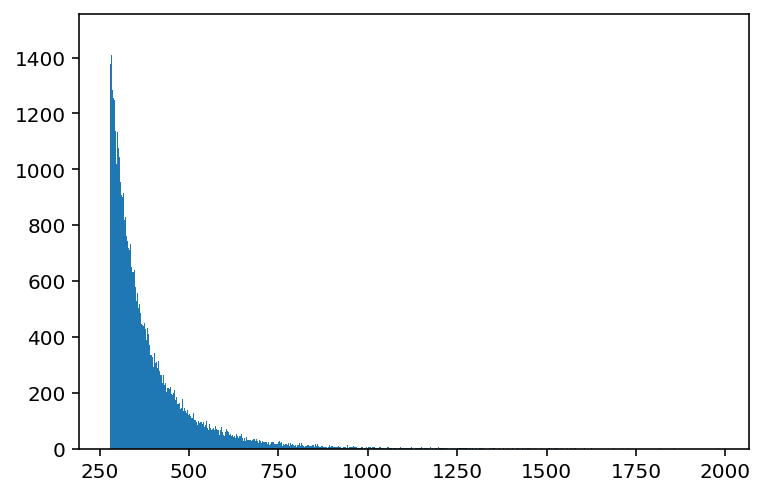

In [100]:
hist = plt.hist(sort_ht[prop],bins = 1000)
plt.show()
counts = hist[0]

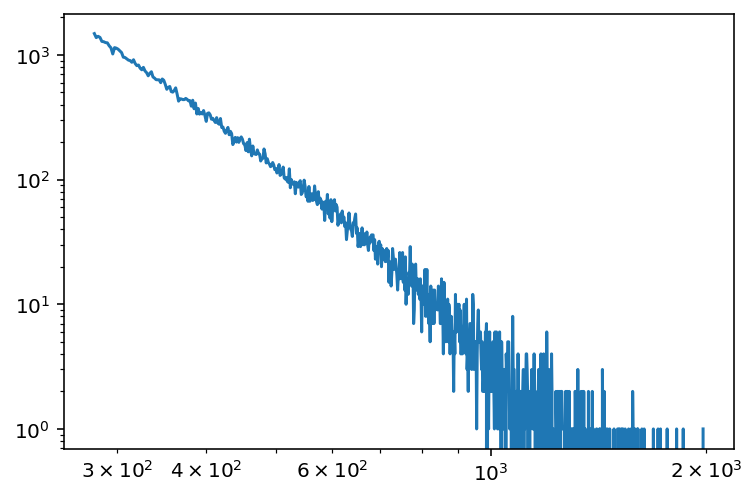

In [101]:
mass=np.linspace(min(sort_ht[prop]),max(sort_ht[prop]),1000)
plt.plot(mass,counts)
plt.xscale('log')
plt.yscale('log')

In [102]:
pos = return_xyz_formatted_array(sort_ht['halo_x'], sort_ht['halo_y'],
                                 sort_ht['halo_z'],period = Lbox)
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]
velz = sort_ht['halo_vz']
pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],verbose=True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.238 secs


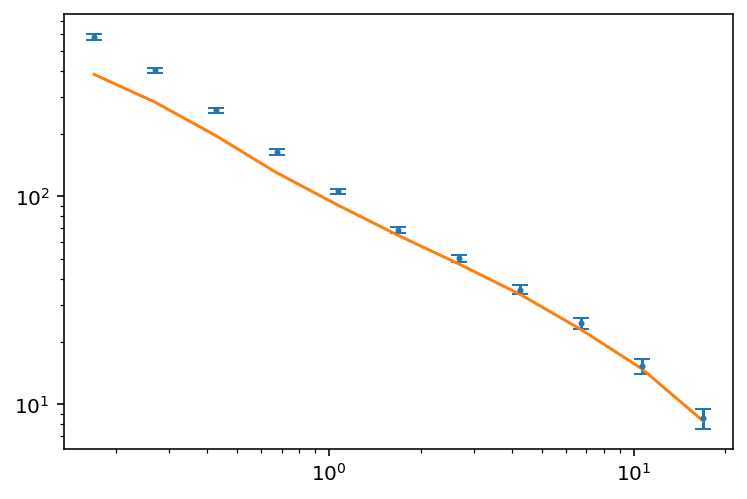

In [103]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen,mod['wp'])
plt.xscale('log')
plt.yscale('log')

In [104]:

def calc_chi2(obs,exp,var):
    chi2s = []
    for wp in obs:
        diff = wp-exp
        chi2 = np.sum(diff**2/var)
        chi2s.append(round(chi2,7))
        
    return chi2s

In [105]:
chi2s = []
diff = mod['wp']-wp_ng_vals[1:12]
chi2 = np.sum(diff**2/err)
chi2s.append(round(chi2,7))
chi2s[0]/7

54.28517551428571

In [106]:
wp_dev = mod['wp']-wp_ng_vals[1:12]
wplike = -0.5*np.dot(np.dot(wp_dev,inv(cov_matrix)), wp_dev)
print(wplike)


-124.21980428958113
